In [1]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectFromModel

from preprocessing import limpiar_datos, aplicar_dummy_variables_encoding, eliminar_features, entrenar_iterative_imputer, imputar_missings_iterative, aplicar_hashing_trick
from graficos_modelos import mostrar_reporte_clasificacion, graficar_auc_roc,graficar_matriz_confusion
from funciones_auxiliares import traer_datasets, traer_dataset_prediccion_final, separar_dataset, encontrar_hiperparametros_RGSCV, mapear_target_binario

# Random Forest

### Obtención de los datos

In [2]:
df, df_sin_target, solo_target = traer_datasets()

X_train, X_test, y_train, y_test = separar_dataset(df_sin_target, solo_target)

X_train.is_copy=False
X_test.is_copy=False
y_train.is_copy=False
y_test.is_copy=False

y_train.set_index('id', inplace=True)
y_train = y_train.sort_values(by=['id'], ascending=True).copy()

y_test.set_index('id', inplace=True)
y_test = y_test.sort_values(by=['id'], ascending=True).copy()


### Definiendo distintos preprocesamientos

Definiremos entonces dos preprocesamientos distintos a comparar para este modelo, y quedarnos con el mejor de ellos cuando probemos en holdout.

In [3]:
def preprocesamiento_1(df_original:pd.DataFrame, imputer=None):
    df = df_original.copy(deep=True)
    df = limpiar_datos(df)
    df = aplicar_hashing_trick(df, ['llovieron_hamburguesas_hoy', 'rafaga_viento_max_direccion'], [1,4])
    eliminar_features(df, ['dia','barrio', 'direccion_viento_tarde', 'direccion_viento_temprano'])
    
    if(imputer is None):
        imputer = entrenar_iterative_imputer(df)
    df = imputar_missings_iterative(df, imputer)
    
    return df, imputer

Vemos que el primero de ellos primero corrije los datos con formato erróneo del dataset, como por ejemplo direcciones IP registradas en la feature 'presion_atmosférica_tarde', o datos que deberían ser NaNs pero son whitespace. Luego aplicaremos un hashing trick para llovieron_hamburguesas_hoy la cual fue una feature de interés en la primera parte del trabajo práctico. Como prueba adicional en este preprocesamiento incluiremos rafaga_viento_max_direccion a las features categóricas que convertirá el hashing trick. Pasamos a eliminar el resto de features categóricas y finalmente completamos los missings con el IterativeImputer.

In [4]:
def preprocesamiento_2(df_original:pd.DataFrame, imputer=None, seleccion_random_forest=None):
    df = df_original.copy(deep=True)
    df = limpiar_datos(df)
    eliminar_features(df, ['dia'])
    df = aplicar_dummy_variables_encoding(df, ['llovieron_hamburguesas_hoy','barrio', 'direccion_viento_tarde', 'direccion_viento_temprano', 'rafaga_viento_max_direccion'])
    if(imputer == None):
        imputer = entrenar_iterative_imputer(df)
    df = imputar_missings_iterative(df, imputer)
    
    if(seleccion_random_forest is None):
        sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
        sel.fit(df, y_train.to_numpy().ravel())
        seleccion_random_forest= df.columns[(sel.get_support())]
    
    eliminar_features(df, df.columns.difference(seleccion_random_forest))
    
    return df, imputer, seleccion_random_forest

El segundo preprocesamiento primero corrije los datos con formato erróneo del dataset, como por ejemplo direcciones IP registradas en la feature 'presion_atmosférica_tarde', o datos que deberían ser NaNs pero son whitespace. Luego se aplica dummy encoding a todas las features categóricas menos el día, que tiene muy alta cardinalidad. Una vez hecho esto, completamos los missings con el IterativeImputer para poder utilizar un clasificador Random Forest como método de selección de atributos. Si bien suena redundante entrenar un RandomForest para seleccionar las features de otro RandomForest, el primero de ellos tendrá un número mucho menor de estimadores y la mayoría de sus hiperparámetros por defecto. Gracias a esta selección, podemos droppear del dataframes aquellas features que RandomForest auxiliar no haya considerado importante para terminar el preprocesamiento.

### Aplicamos preprocesamientos 1 y 2 para obtener X_train_1 / X_test_1 y X_train_2 / X_test_2 respectivamente

In [5]:
X_train_1, imputer_entrenado_1 = preprocesamiento_1(X_train)
X_test_1, imputer_entrenado_1 = preprocesamiento_1(X_test, imputer_entrenado_1)

In [6]:
X_train_2, imputer_entrenado_2, seleccion_RF = preprocesamiento_2(X_train)
X_test_2, imputer_entrenado_2, seleccion_RF = preprocesamiento_2(X_test, imputer_entrenado_2, seleccion_RF)

### Búsqueda de Hiperparámetros para el modelo que entrenará sobre X_train_1

Buscamos hiperparámetros con RandomGridSearch, pues GridSearch iterativamente es bastante lento. Para RandomForest, estos hiperparámetros serán:
* criterion: La función para medir la calidad de una división.
* n_estimators: La cantidad de árboles en el bosque.
* max_ depth: La profundidad máxima del árbol.

In [7]:
params = {'criterion': ['gini','entropy'], 'n_estimators':[100,300,500],'max_depth': np.arange(3,12)}
hiperparametros = encontrar_hiperparametros_RGSCV(RandomForestClassifier(), params=params, x_np=X_train_1.to_numpy(), y_np=y_train.to_numpy().ravel())

C:\Users\Guillermo\anaconda3\envs\orgadatos\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 54 is smaller than n_iter=100. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [8]:
criterio_elegido_1 = hiperparametros['criterion']
cantidad_estimadores_elegida_1 = hiperparametros['n_estimators']
profundidad_elegida_1 = hiperparametros['max_depth']
print(f'Mejor criterio: {criterio_elegido_1}')
print(f'Mejor cantidad de estimadores: {cantidad_estimadores_elegida_1}')
print(f'Mejor profundidad_maxima: {profundidad_elegida_1}')

Mejor criterio: entropy
Mejor cantidad de estimadores: 500
Mejor profundidad_maxima: 11


### Entrenando el Modelo 1 sobre X_train_1 con CrossValidation

Procedemos a testear con kfolds, stratificados pues nuestro dataset es desbalanceado. Además, usamos los hiperparámetros encontrados previamente.

In [9]:
kf = StratifiedKFold(n_splits=5)
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train_1, y_train)):
    bosque_clasificacion = RandomForestClassifier(max_depth=profundidad_elegida_1, n_estimators=cantidad_estimadores_elegida_1, criterion=criterio_elegido_1)
    bosque_clasificacion.fit(X_train_1.iloc[train_index], y_train.iloc[train_index].values.ravel())
    print ('Reporte para el FOLD ' + str(fold_idx))
    print(classification_report(y_train.iloc[test_index], bosque_clasificacion.predict(X_train_1.iloc[test_index]), target_names=['No llueven hamburguesas al dia siguiente', 'Llueven hamburguesas al dia siguiente']))
    

Reporte para el FOLD 0
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.86      0.96      0.91     15891
   Llueven hamburguesas al dia siguiente       0.77      0.44      0.56      4581

                                accuracy                           0.85     20472
                               macro avg       0.81      0.70      0.73     20472
                            weighted avg       0.84      0.85      0.83     20472

Reporte para el FOLD 1
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.87      0.92      0.90     15891
   Llueven hamburguesas al dia siguiente       0.66      0.53      0.59      4580

                                accuracy                           0.83     20471
                               macro avg       0.77      0.72      0.74     20471
                            weighted avg       

### Búsqueda de Hiperparámetros para el modelo que entrenará sobre X_train_2

Buscamos hiperparámetros con RandomGridSearch, pues GridSearch iterativamente es bastante lento. Para RandomForest, estos hiperparámetros serán:
* criterion: La función para medir la calidad de una división.
* n_estimators: La cantidad de árboles en el bosque.
* max_ depth: La profundidad máxima del árbol.

In [10]:
params = {'criterion': ['gini','entropy'], 'n_estimators':[100,300,500],'max_depth': np.arange(3,12)}
hiperparametros = encontrar_hiperparametros_RGSCV(RandomForestClassifier(), params=params, x_np=X_train_2.to_numpy(), y_np=y_train.to_numpy().ravel())

C:\Users\Guillermo\anaconda3\envs\orgadatos\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 54 is smaller than n_iter=100. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [11]:
criterio_elegido_2 = hiperparametros['criterion']
cantidad_estimadores_elegida_2 = hiperparametros['n_estimators']
profundidad_elegida_2 = hiperparametros['max_depth']
print(f'Mejor criterio: {criterio_elegido_2}')
print(f'Mejor cantidad de estimadores: {cantidad_estimadores_elegida_2}')
print(f'Mejor profundidad_maxima: {profundidad_elegida_2}')

Mejor criterio: entropy
Mejor cantidad de estimadores: 500
Mejor profundidad_maxima: 11


### Entrenando el Modelo 2 sobre X_train_2 con CrossValidation

Procedemos a testear con kfolds, stratificados pues nuestro dataset es desbalanceado. Además, usamos los hiperparámetros encontrados previamente.

In [12]:
kf = StratifiedKFold(n_splits=5)
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train_2, y_train)):
    bosque_clasificacion = RandomForestClassifier(max_depth=profundidad_elegida_2, n_estimators=cantidad_estimadores_elegida_2, criterion=criterio_elegido_2)
    bosque_clasificacion.fit(X_train_2.iloc[train_index], y_train.iloc[train_index].values.ravel())
    print ('Reporte para el FOLD ' + str(fold_idx))
    print(classification_report(y_train.iloc[test_index], bosque_clasificacion.predict(X_train_2.iloc[test_index]), target_names=['No llueven hamburguesas al dia siguiente', 'Llueven hamburguesas al dia siguiente']))
    

Reporte para el FOLD 0
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.86      0.96      0.91     15891
   Llueven hamburguesas al dia siguiente       0.77      0.44      0.56      4581

                                accuracy                           0.84     20472
                               macro avg       0.81      0.70      0.73     20472
                            weighted avg       0.84      0.84      0.83     20472

Reporte para el FOLD 1
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.87      0.92      0.90     15891
   Llueven hamburguesas al dia siguiente       0.66      0.53      0.59      4580

                                accuracy                           0.83     20471
                               macro avg       0.77      0.73      0.74     20471
                            weighted avg       

### Predicción del modelo sobre holdout con el modelo que mejor resultó al hacer CrossValidation: Modelo 1

Una vez entrenados y validados los modelos con CrossValidation, viendo que las métricas resultantes fueron razonables y no dan indicio de overfit o mala división del dataset, debemos elegir unos de ellos para probar en Holdout. Las métricas resultaron tan similares en este caso, que optaremos por simplemente usar el modelo que requirió menor complejidad en su preprocesamiento, el modelo 1. Pasaremos a probar dicho modelo en la partición Holdout. Para esto usaremos los mejores hiperparámetros hallados previamente en Training.

In [14]:
bosque_holdout = RandomForestClassifier(max_depth=profundidad_elegida_1, n_estimators=cantidad_estimadores_elegida_1, criterion=criterio_elegido_1)
bosque_holdout.fit(X_train_1.to_numpy(), y_train.to_numpy())

C:\Users\GUILLE~1\AppData\Local\Temp/ipykernel_5876/7780460.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  bosque_holdout.fit(X_train_1.to_numpy(), y_train.to_numpy())


RandomForestClassifier(criterion='entropy', max_depth=11, n_estimators=500)

In [15]:
mapeo_binario_v = np.vectorize(mapear_target_binario)
y_pred = bosque_holdout.predict(X_test_1.to_numpy())
y_pred_binario = mapeo_binario_v(y_pred)
y_pred_proba = bosque_holdout.predict_proba(X_test_1.to_numpy())[:, 1]
y_test_binario = y_test['llovieron_hamburguesas_al_dia_siguiente'].map({'si': 1, 'no': 0}).to_numpy()
print(classification_report(y_test['llovieron_hamburguesas_al_dia_siguiente'].to_numpy(), y_pred))

              precision    recall  f1-score   support

          no       0.86      0.96      0.91      8828
          si       0.76      0.47      0.58      2545

    accuracy                           0.85     11373
   macro avg       0.81      0.71      0.74     11373
weighted avg       0.84      0.85      0.83     11373



### Curva AUC ROC


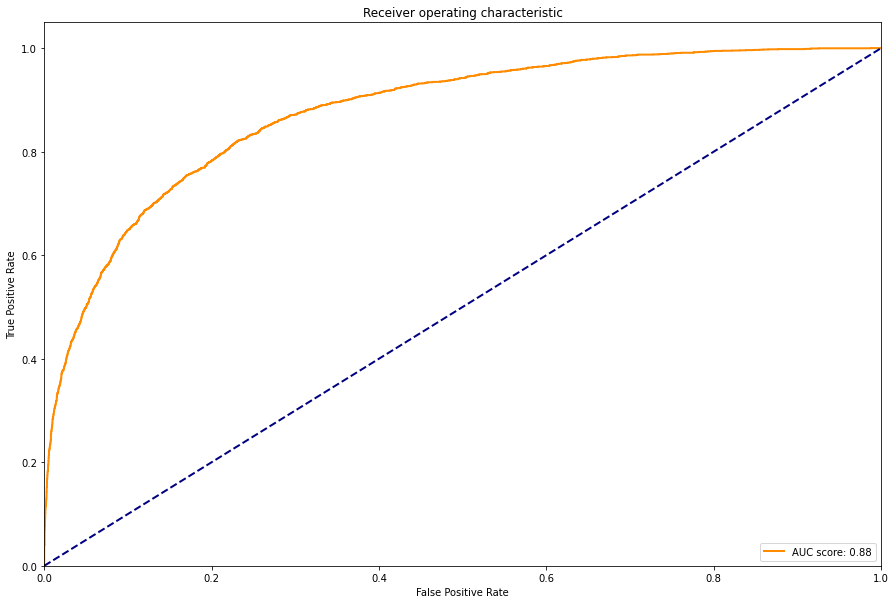

AUC-ROC para este modelo es: 0.8769294965207151


In [16]:
graficar_auc_roc(y_test_binario, y_pred_proba)

Vemos que la curva AUC-ROC para este modelo, es muy superior a la mayoría de los otros modelos los cuales oscilan en el rango de 0.85-0,82, siendo incluso ligeramente superior al ensamble de boosting. Al ser un modelo bastante complejo, es predecible que su performance este entre las mejores.

### Matriz de confusion

C:\Users\Guillermo\anaconda3\envs\orgadatos\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


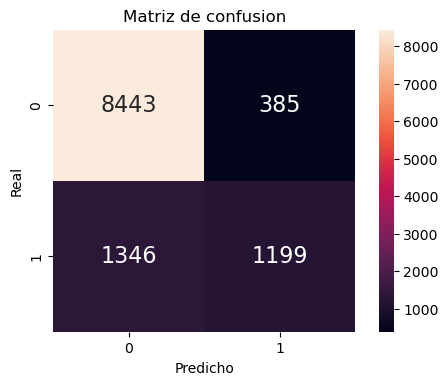

In [17]:
graficar_matriz_confusion(y_test_binario, y_pred_binario)

Vemos que al igual que en el modelo de boosting, este modelo presenta las mejores metricas de accuracy y AUC-ROC, pero sigue manteniendo metricas promedio para recall y precision, siendo el recall menor a 0.5, y el precision menor 0.8

## Predicción con el dataset nuevo
A continuación, realizamos la predicción con el RandomForest sobre el dataset de predicciones nuevo, y la escribimos al archivo 'RandomForest.csv'

In [18]:
from funciones_auxiliares import exportar_prediccion_final

df_prediccion_final = traer_dataset_prediccion_final()
ids = df_prediccion_final['id'].to_numpy()

df_prediccion_final, imputer_entrenado_1 = preprocesamiento_1(df_prediccion_final, imputer_entrenado_1)
predicciones = bosque_holdout.predict(df_prediccion_final.to_numpy())

exportar_prediccion_final(ids, predicciones, 'RandomForest')